TODO : generaliser à images 32x32, etc.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
#from waveimage import WaveImage, calc_dim, calc_U, mnist_reshape_32
from waveimage import WaveImage, calc_dim, calc_U, mnist_reshape_32

In [4]:
from scipy.stats import multivariate_normal, entropy

In [5]:
import math

In [6]:
import sys, os

In [7]:
import pickle

In [8]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [9]:
from waveimage import calc_U

In [10]:
MODEL = 'base'
#MODEL = 'base' 
if MODEL == 'base':
    mu, Sigma, rho = pickle.load(open("mnist-waveimage-train-mu-Sigma-rho.pkl", "rb"))
elif MODEL == 'naive':
    mu, Sigma, rho = pickle.load(open("mnist-waveimage-train-mu-Sigma-rho-naive.pkl", "rb"))
elif MODEL == 'naive-test':
    mu, Sigma, rho = pickle.load(open("mnist-waveimage-train-mu-Sigma-rho.pkl", "rb"))
#mu, Sigma, rho = pickle.load(open("mnist-waveimage-train-mu-Sigma-rho-noisy-alt.pkl", "rb"))

## Creation de la base d'apprentissage

In [11]:
def wave_tensor_data(batch_x):
    batch_size, _ = batch_x.shape
    wave_tensor = {}
    for h in range(6):
        if h == 0:
            h_size = 1
            wave_tensor[h] = np.zeros((batch_size, h_size, h_size, 1))
        else:
            h_size = 2**(h - 1)
            wave_tensor[h] = np.zeros((batch_size, h_size, h_size, 3))
    for num_batch in range(batch_size):
        image = mnist_reshape_32(batch_x[num_batch])
        w = WaveImage(image = image)
        for h in range(w.get_h_max()):
            data_h = w.get_data()[h]
            if h == 0:
                wave_tensor[h][num_batch][0][0][0] = data_h[(0,0)]
            else:
                for u in data_h:
                    wave_tensor[h][num_batch][u[0]][u[1]][:] = data_h[u]
    return wave_tensor

In [12]:
def calc_pow2(i_ref):
    pow2_i = np.zeros(5, dtype='int')
    reste = i_ref
    for p in range(4,-1,-1):
        pow2_i[p] = int(reste // 2**p)
        #reste = reste % 2**p
    return pow2_i[::-1]


In [13]:
print calc_pow2(15)

[ 0  1  3  7 15]


In [14]:
def init_wave_tensor(batch_size):
    wave_tensor = {}
    for h in range(6):
        if h == 0:
            h_size = 1
            wave_tensor[h] = np.zeros((batch_size, h_size, h_size, 1))
        else:
            h_size = 2**(h - 1)
            wave_tensor[h] = np.zeros((batch_size, h_size, h_size, 3))
    return wave_tensor
    

In [15]:
def wave_tensor_data_backbone(batch_x, depth = -1, i_ref = -1, j_ref = -1):
    batch_size, _ = batch_x.shape
    FLAG_RAND_I = i_ref == -1
    FLAG_RAND_J = j_ref == -1
    FLAG_DEPTH = depth == -1
    wave_tensor = init_wave_tensor(batch_size)
    for num_batch in range(batch_size):
        image = mnist_reshape_32(batch_x[num_batch])
        w = WaveImage(image = image)
        if FLAG_RAND_I:
            i_ref = np.random.randint(16)
        if FLAG_RAND_J:
            j_ref = np.random.randint(16)  
        if FLAG_DEPTH:
            depth = 1 + np.random.randint(6)
        pow2_i = calc_pow2(i_ref)
        pow2_j = calc_pow2(j_ref)
        for h in range(6 - depth, 6):
            data_h = w.get_data()[h]
            if h == 0:
                wave_tensor[h][num_batch][0][0][0] = data_h[(0,0)] #/ 4**4
            else:
                u = (pow2_i[h - 1], pow2_j[h - 1])
                #for u in data_h:
                #    wave_tensor[h][num_batch][u[0]][u[1]][:] = 0
                wave_tensor[h][num_batch][u[0]][u[1]][:] = data_h[u] #/ 4 ** (5 - h)
    return wave_tensor

Construction 
+ 5 couches convolutionnelles : 16 x 16 --> 8 x 8 ; 8 x 8 --> 4 x 4 etc
+ 1 couche FC

In [16]:
DEPTH_WAV = 3
NB_LABEL = 10

In [17]:
# Likelihood calculation (over z's, for given v, h and u)

def calc_lik(v,h,u):
    lik = np.zeros(10)
    for c in range(10):
        if np.linalg.norm(v) < 1e-16:
            if np.linalg.norm(mu[c][h][u]) > 1e-16:
                lik[c] = rho[c][h][u]
            else:
                lik[c] = 1                
        else:
            if np.linalg.norm(mu[c][h][u]) > 1e-16:
                if h == 0:
                    dist = multivariate_normal(mean = mu[c][h][u], cov = Sigma[c][h][u])
                else:
                    dist = multivariate_normal(mean = mu[c][h][u], cov = Sigma[c][h][u] + 1e-10 * np.eye(3))
                lik[c] = (1-rho[c][h][u]) * dist.pdf(v)
                #lik[c] =  dist.pdf(v)
            else:
                lik[c] = 0
        lik[c] = max(lik[c],1e-16)    
    return lik

In [18]:
# Likelihood calculation (over z's, for given v, h and u)

def calc_lik_naive(v,h,u):
    lik = np.zeros(10)
    for c in range(10):
        '''if np.linalg.norm(v) < 1e-16:
            if np.linalg.norm(mu[c][h][u]) > 1e-16:
                lik[c] = rho[c][h][u]
            else:
                lik[c] = 1                
        else:
            if np.linalg.norm(mu[c][h][u]) > 1e-16:'''
        if h == 0:
            dist = multivariate_normal(mean = mu[c][h][u], cov = Sigma[c][h][u])
        else:
            dist = multivariate_normal(mean = mu[c][h][u], cov = np.diag(Sigma[c][h][u] + 1e-10))
            #lik[c] = (1-rho[c][h][u]) * dist.pdf(v)
            lik[c] =  dist.pdf(v)
        '''else:
            lik[c] = 0'''
        lik[c] = max(lik[c], 1e-16)    
    return lik

In [19]:
# Log posterior

def update_log_score(log_score, lik):
    #print 'lik =' + str(lik) 
    log_score += np.log(lik) 
    max_log_score = max(log_score)
    log_score -= max_log_score
    return log_score

In [20]:
# Posterior (Softmax)
    
def calc_pi(log_score): # TODO
    Z = np.sum(np.exp(log_score))
    pi = np.exp(log_score)/Z
    #print 'pi =' + str(pi)
    #print 'max(pi) = ',max(pi)
    return pi

# Parcours predictif

In [21]:
pi_predictive_eff = pickle.load(open("mnist-waveimage-saliency-map.pkl", "rb"))    
#pi_predictive_eff = pickle.load(open("mnist-waveimage-saliency-map-diff-backbone-CNN-parts.pkl", "rb"))    

In [22]:
H_generic_eff = pickle.load(open("mnist-waveimage-generic-saliency-map.pkl", "rb"))    
#pi_predictive_eff = pickle.load(open("mnist-waveimage-saliency-map-diff-backbone-CNN-parts.pkl", "rb"))    

In [23]:
def calcule_asc_path(h,u):
    rep = []
    for h_inf in range(h, 0, -1):
        i_inf = u[0] / (2 ** (h - h_inf))
        j_inf = u[1] / (2 ** (h - h_inf))
        rep += [(h_inf, (i_inf, j_inf))]
    # racine
    rep += [(0, (i_inf, j_inf))]
    return rep

In [24]:
def calc_pi_predictive_sorted(pi_predictive): 
    pi_predictive_sorted = {}
    for c in range(10):
        pi_predictive_sorted[c] = []
        for k in pi_predictive[c]:
            pi_predictive_sorted[c] += [(pi_predictive[c][k], k)]
        pi_predictive_sorted[c] = sorted(pi_predictive_sorted[c])
    return pi_predictive_sorted

In [25]:
def calc_H_predictive_sorted(H_predictive): 
    H_predictive_sorted = []
    for k in H_predictive:
        H_predictive_sorted += [(H_predictive[k], k)]
    H_predictive_sorted = sorted(H_predictive_sorted, reverse=True)
    return H_predictive_sorted

In [26]:
def argmax_generator(c, h, u):
    test_pred = rho[c][h][u] < .5       
    if test_pred:
        return mu[c][h][u]
    else:
        return np.zeros(3)

In [27]:
def softmax_generator(log_score, h, u):
    Z = np.sum(np.exp(log_score))
    mu_c = np.zeros(3)
    for c in range(NB_LABEL):
        pi = np.exp(log_score[0][c]) / Z
        mu_c += pi * mu[c][h][u] * (1 - rho[c][h][u])
    return mu_c

In [28]:
axes = []
h_max = 6
shape = (32,32)

U = {}
for h in range(h_max):
    U [h] = {}
    dim_i, dim_j = calc_dim(shape, h, h_max)
    for i in range(dim_i):
        for j in range(dim_j):
            U[h][(i,j)] = 1    

In [29]:
MODEL

'base'

h_max = 6
lik_predictive = {}
for c in range(10):
    lik_predictive[c] = {}
    for h in range(h_max):
        lik_predictive[c][h] = {}
        for u in U[h]:
            v_predictive = argmax_generator(c, h, u)
            if MODEL == 'base':
                lik = calc_lik(v_predictive, h, u)
            elif MODEL == 'naive':
                lik = calc_lik_naive(v_predictive, h, u)
            lik_predictive[c][h][u] = lik

In [30]:
h_max = 6
if MODEL == 'base':
    lik_predictive_base = {}
elif MODEL == 'naive' or MODEL == 'naive-test':  
    lik_predictive_naive = {}
for c in range(10):
    if MODEL == 'base':
        lik_predictive_base[c] = {}
    elif MODEL == 'naive' or MODEL == 'naive-test':  
        lik_predictive_naive[c] = {}
    for h in range(h_max):
        if MODEL == 'base':
            lik_predictive_base[c][h] = {}
        elif MODEL == 'naive' or MODEL == 'naive-test':  
            lik_predictive_naive[c][h] = {}
        for u in U[h]:
            v_predictive = argmax_generator(c, h, u)
            if MODEL == 'base':
                lik = calc_lik(v_predictive, h, u)
                lik_predictive_base[c][h][u] = lik
            elif MODEL == 'naive' or MODEL == 'naive-test':
                lik = calc_lik_naive(v_predictive, h, u)
                lik_predictive_naive[c][h][u] = lik

In [31]:
def predictive_search(z_ref, log_score, actions_set, mem_h_u, FLAG_POL = 'Info Gain'):
    # actions_set ne contient que les positions de niveau 5
    h_ref = 5
    batch_size = len(actions_set)
    #print batch_size
    ## Parcours predictif
    log_score_path = np.zeros((batch_size, NB_LABEL))
    for i, u_gen in enumerate(actions_set):
        log_score_path[i] = np.copy(log_score[0])
    dict_u = {}
    for i, u_gen in enumerate(actions_set):
        dict_u[i] = u_gen
        liste_path = calcule_asc_path(h_ref, u_gen)
        #print(liste_path)
        for (h_path, u_path) in liste_path[:-1]:
            #print(h_path, u_path)
            if (h_path, u_path) not in mem_h_u:
                log_score_path[i] = update_log_score(log_score_path[i], lik_predictive[z_ref][h_path][u_path])
        #print log_score_path[i]
        
    q_pre = np.exp(log_score[0]) / np.sum(np.exp(log_score[0]))
    FEP_post = np.zeros(batch_size)
    for i, u_gen in enumerate(actions_set):
        if FLAG_POL != 'Info Gain':
            q_post = np.exp(log_score_path[i]) / np.sum(np.exp(log_score_path[i])) 
            if FLAG_POL == 'Infomax':
                FEP_post[i] = entropy(q_post)
            elif FLAG_POL == 'Innovative':
                FEP_post[i] = - entropy(q_post, q_pre)
            elif FLAG_POL == 'Conservative':
                FEP_post[i] = - np.log(q_post[z_ref])
        else: # FLAG_POL == 'Info Gain'
            delta_log_score_path = log_score_path[i] - log_score[0]
            delta_q_post = np.exp(delta_log_score_path) / np.sum(np.exp(delta_log_score_path))
            FEP_post[i] = - np.log(delta_q_post[z_ref])
        if not np.isfinite(FEP_post[i]):
            print "aie!!"
            FEP_post[i] = 50
                
    #i_max = np.where(log_score_path[:, z_ref] == max(log_score_path[:, z_ref]))[0][0]
    i_min = np.where(FEP_post == min(FEP_post))[0][0]
    q_post = np.exp(log_score_path[i_min]) / np.sum(np.exp(log_score_path[i_min])) 
    delta_log_score_path = log_score_path[i_min] - log_score[0]
    delta_q_post = np.exp(delta_log_score_path) / np.sum(np.exp(delta_log_score_path))
    #print log_score_path[i_min] 
    #print dict_u[i_min] , entropy(q_post), - np.log(delta_q_post[z_ref]) + np.log(q_pre[z_ref]), FEP_post[i_min]
    
    
    ## 3 ##
    return dict_u[i_min] #, pi_path[i_max] #pi_path[i_max][z_ref]
    

In [104]:
def FEP_predictive_search_full(log_score, actions_set, mem_h_u, FLAG_POL = 'Info Gain'):
    # actions_set ne contient que les positions de niveau 5
    h_ref = 5
    batch_ref = len(actions_set)
    batch_size = batch_ref * NB_LABEL
    log_score_path = {}
    
    ## Parcours predictif
    log_score_path = np.zeros((batch_size, NB_LABEL))
    for i, u_gen in enumerate(actions_set):
        for c in range(NB_LABEL):
            i_full = c * batch_ref + i
            log_score_path[i_full] = np.copy(log_score[0])
    dict_u = {}
    for i, u_gen in enumerate(actions_set):
        dict_u[i] = u_gen
        liste_path = calcule_asc_path(h_ref, u_gen)
        #print(liste_path)
        for (h_path, u_path) in liste_path[:-1]:
            #print(h_path, u_path)
            if (h_path, u_path) not in mem_h_u:
                for c in range(NB_LABEL):
                    i_full = c * batch_ref + i
                    log_score_path[i_full] = update_log_score(log_score_path[i_full],\
                                                              lik_predictive[c][h_path][u_path])
                        
    FEP_post = np.zeros(batch_size)
    q_pre = np.exp(log_score[0]) / np.sum(np.exp(log_score[0]))
    '''log_score_post_full = np.zeros((batch_ref,))
    for c in range(NB_LABEL):
        log_score_post_full += q_pre[c] * log_score_path[i_full]    #print q_pre'''
        
    for i, u_gen in enumerate(actions_set):
        for c in range(NB_LABEL):
            i_full = c * batch_ref + i
            if FLAG_POL != 'Info Gain':
                q_post = np.exp(log_score_path[i_full]) / np.sum(np.exp(log_score_path[i_full]))  
                if FLAG_POL == 'Infomax':
                    FEP_post[i_full] = entropy(q_post)
                elif FLAG_POL == 'Innovative':
                    FEP_post[i_full] = - entropy(q_post, q_pre)
                elif FLAG_POL == 'Conservative':
                    FEP_post[i_full] = - np.log(q_post[c])
            else: # FLAG_POL == 'Info Gain'
                delta_log_score_path = log_score_path[i_full] - log_score[0]
                delta_q_post = np.exp(delta_log_score_path) / np.sum(np.exp(delta_log_score_path))
                FEP_post[i_full] = - np.log(delta_q_post[c])
            if not np.isfinite(FEP_post[i_full]):
                print "aie!!"
                FEP_post[i_full] = 50
                
    #ch = raw_input('')    
    FEP_post_full = np.zeros((batch_ref,))
    for c in range(NB_LABEL):
        FEP_post_full += q_pre[c] * FEP_post[c * batch_ref : (c + 1) * batch_ref]
        #print FEP_post[c * batch_ref : (c + 1) * batch_ref]
        
    #for i, u_gen in enumerate(actions_set):
    #    print u_gen, FEP_post_full[i]
    
    #print FEP_post_full
    i_min = np.where(FEP_post_full == min(FEP_post_full))[0][0]
    #print i_min, dict_u[i_min], FEP_post_full[i_min]
    ## 3 ##
    return dict_u[i_min]  #pi_path[i_max][z_ref]
    

In [33]:
def prediction_based_policy(log_score, actions_set, mem_h_u, FLAG_POL = 'Info Gain'):
    
    ## 1 ##
    z_tilde = np.argmax(log_score)    
    u_tilde = predictive_search(z_tilde, log_score, actions_set, mem_h_u, FLAG_POL)
    
    return u_tilde

In [34]:
def FEP_prediction_based_policy(log_score, actions_set, mem_h_u, FLAG_POL = 'Info Gain'):
    
    u_tilde = FEP_predictive_search_full(log_score, actions_set, mem_h_u, FLAG_POL)
    
    return u_tilde

In [35]:
def saliency_based_policy(log_score, pi_predictive_sorted, mem_h_u):
    h = 5
    ## 1 ##
    z_tilde = np.argmax(log_score)
    u_tilde = pi_predictive_sorted[z_tilde].pop()[1]
    while (h, u_tilde) in mem_h_u:
        u_tilde = pi_predictive_sorted[z_tilde].pop()[1]
    return u_tilde
    

In [36]:
def generic_saliency_based_policy(H_predictive_sorted, mem_h_u):
    u_tilde = H_predictive_sorted.pop()[1]
    return u_tilde

In [37]:
def random_policy(log_score, mem_h_u):
    h = 5
    ## 1 ##
    z_tilde = np.argmax(log_score)
    #u_tilde = (1 + np.random.randint(14),  1 + np.random.randint(14))
    u_tilde = (np.random.randint(16),  np.random.randint(16))
    while (h, u_tilde) in mem_h_u:
        #u_tilde = (1 + np.random.randint(14),  1 + np.random.randint(14))
        u_tilde = (np.random.randint(16),  np.random.randint(16))
    return u_tilde

In [80]:
def scene_exploration(wave_tensor_ref, log_score, z_ref, ind_test, actions_set, mem_h_u, record, \
                      POL = 'predictive', AFF = True, THRESHOLD = 1e-4, INIT = 'limit'):
    
    assert POL == 'predictive' or POL == 'predictive-dual' or POL == 'predictive-KL'\
    or POL == 'saliency-based' or POL == 'random' or POL == 'full' or POL == 'generic-saliency-based'\
    or POL == 'FEP-predictive' or POL == 'FEP-predictive-dual' or POL == 'FEP-predictive-KL'
    
    if POL == 'full':
        THRESHOLD = 0
        POL = 'saliency-based'
    
    TOUR = 0
    END = False
    h_ref = 5
    
    # saliency-based approach
    if POL == 'saliency-based':
        pi_predictive_sorted = calc_pi_predictive_sorted(pi_predictive_eff)
    if True : #POL == 'generic-saliency-based':
        H_predictive_sorted = calc_H_predictive_sorted(H_generic_eff)     
    while END == False:
        
        if AFF:
            print '************************************'
            print '******       TOUR    ' + str(TOUR + 1) + '        ******'
            print '************************************'
        
        # 1. CHOIX
        if POL == 'predictive':
            if TOUR == 0 and INIT == 'H0-init':
                u_tilde = H_predictive_sorted[-1][1]
            else:
                u_tilde = prediction_based_policy(log_score, actions_set, mem_h_u)
        elif POL == 'predictive-dual':
            if TOUR == 0  and INIT == 'H0-init':
                u_tilde = H_predictive_sorted[-1][1]
            else:
                u_tilde = prediction_based_policy(log_score, actions_set, mem_h_u, FLAG_DUAL = True)
        elif POL == 'predictive-KL' and INIT == 'H0-init':
            if TOUR == 0 and INIT == 'H0-init':
                u_tilde = H_predictive_sorted[-1][1]
            else:
                u_tilde = prediction_based_policy(log_score, actions_set, mem_h_u, FLAG_DUAL = True, FLAG_KL = True)
            #print u_tilde
        elif POL == 'FEP-predictive-dual':
            if TOUR == 0 and INIT == 'H0-init':
                u_tilde = H_predictive_sorted[-1][1]
            else:
                u_tilde = FEP_prediction_based_policy(log_score, actions_set, mem_h_u,\
                                                      FLAG_DUAL = True, FLAG_FULL = True)
            #print u_tilde
            #ch = raw_input('')     
        elif POL == 'FEP-predictive':
            if TOUR == 0 and INIT == 'H0-init':
                u_tilde = H_predictive_sorted[-1][1]
            else:
                u_tilde = FEP_prediction_based_policy(log_score, actions_set, mem_h_u,\
                                                      FLAG_DUAL = False, FLAG_FULL = True)
            #print u_tilde, H_predictive_sorted[-1]
        elif POL == 'FEP-predictive-KL':
            if TOUR == 0  and INIT == 'H0-init':
                u_tilde = H_predictive_sorted[-1][1]
            else:
                u_tilde = FEP_prediction_based_policy(log_score, actions_set, mem_h_u,\
                                                      FLAG_DUAL = True, FLAG_FULL = True, FLAG_KL = True)    
            #print u_tilde
            #ch = raw_input('')    
        elif POL == 'saliency-based' and INIT == 'H0-init':
            if TOUR == 0:
                u_tilde = H_predictive_sorted[-1][1]
            else:
                u_tilde = saliency_based_policy(log_score, pi_predictive_sorted, mem_h_u)
        elif POL == 'generic-saliency-based':
            u_tilde = generic_saliency_based_policy(H_predictive_sorted, mem_h_u)
        else:
            u_tilde = random_policy(log_score, mem_h_u)
        
        if AFF:
            print 'CHOIX :', u_tilde
        
        # 2. LECTURE + UPDATE
        #wave_tensor =  init_wave_tensor(1)
        liste_path = calcule_asc_path(h_ref, u_tilde)
        
        for (h_path, u_path) in reversed(liste_path):
            if (h_path, u_path) not in mem_h_u:
                v = wave_tensor_ref[h_path][0][u_path[0]][u_path[1]][:]
                lik = calc_lik(v, h_path, u_path)
                log_score[0] = update_log_score(log_score[0], lik)
                #wave_tensor[h_path][0][u_path[0]][u_path[1]][:] =  
                mem_h_u += [(h_path, u_path)]
                record.mem_h_u += [(h_path, u_path)]
                record.nb_coeffs += 3  
                
        pi = np.exp(log_score[0]) / np.sum(np.exp(log_score[0])) #sess.run(tf.nn.softmax(log_score))[0]
                
        H = entropy(pi) # sess.run(tf.nn.softmax_cross_entropy_with_logits(labels=pi,logits=log_score)) #np.sum(- pi * np.log(pi))
        out = np.argmax(pi)
                
        if AFF :
            print 'pi : ', pi
            print 'out :', out
            print 'pi[out] : ', pi[out]
            print 'H : ', H

        record.mem_pi += [pi]
        record.mem_H += [H]
        record.mem_z += [out]
                
        # 3. INHIBITION OF RETURN        
        actions_set.pop(u_tilde)
        
        record.mem_u += [u_tilde]
        record.nb_saccades += 1
                
        if AFF:
            print '****', 'z :', z_ref, ', u :',u_tilde, ' ---> ', out
              
        
        if TOUR == 16 * 16 - 1 or H < THRESHOLD:
            END = True
            if AFF :
                print '************************************'
                print '******         FINI          *******'
                print '************************************' 
            return out
        else:
            TOUR += 1   

## Main

In [39]:
from record import Record, affiche_records            

In [40]:
NB_TRIALS = 1000

In [41]:
mnist = input_data.read_data_sets("MNIST_data/")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


    Policy : predictive, threshold : 0.03, 4 saccades, initial : 3, final : 7, classe : 7, elapsed time : 4.96038
    Policy : predictive, threshold : 0.03, 4 saccades, initial : 0, final : 2, classe : 2, elapsed time : 9.72888
    Policy : predictive, threshold : 0.03, 1 saccades, initial : 1, final : 1, classe : 1, elapsed time : 11.6165
    Policy : predictive, threshold : 0.03, 2 saccades, initial : 0, final : 0, classe : 0, elapsed time : 14.5421
    Policy : predictive, threshold : 0.03, 8 saccades, initial : 4, final : 4, classe : 4, elapsed time : 22.9571
    Policy : predictive, threshold : 0.03, 1 saccades, initial : 1, final : 1, classe : 1, elapsed time : 24.8637
    Policy : predictive, threshold : 0.03, 3 saccades, initial : 7, final : 4, classe : 4, elapsed time : 28.7859
    Policy : predictive, threshold : 0.03, 4 saccades, initial : 8, final : 9, classe : 9, elapsed time : 33.8153
    Policy : predictive, threshold : 0.03, 10 saccades, initial : 2, final : 5, classe : 5, elapsed time : 44.5951
    Policy : predictive, threshold : 0.03, 3 saccades, initial : 0, final : 9, classe : 9, elapsed time : 48.4158

In [42]:
# Test generic saliency map

In [105]:
import time
dict_records = {}

#file_name = "mnist-waveimage-CNN-backbone-records-rnd-parts-generic-saliency.npy"
#file_name = "mnist-waveimage-records-FEP-dual-full-H0_init-IMOL-9.npy" #random.npy" #-naive-bayes.npy"
#file_name = "mnist-waveimage-records-FEP-dual-full-naive-bayes.npy"
file_name = "tmp"
INIT = 'H0-init' #

if MODEL == 'base':
    lik_predictive = lik_predictive_base
elif MODEL == 'naive' or MODEL == 'naive-test':
    lik_predictive = lik_predictive_naive

if True : #not os.path.isfile(file_name):
    # IMOL change 
    # FEP-predictive-KL : PUC
    # FEP-predictive-dual : -PEC
    # FEP-predictive : Infomax
    for POL in ('FEP-predictive-dual',): # 'FEP-predictive', 'FEP-predictive-KL'):#,  'random',): #, 'FEP-predictive-KL', 'saliency-based', \
               # 'generic-saliency-based', 'random', 'predictive-KL', 'predictive-dual', 'predictive',): # 'FEP-predictive'): #'generic-saliency-based',): 

        dict_records[POL] = {}

        for THRESHOLD in (1e-1, 1e-2, 1e-3, 1e-4, 1e-5):
        #for THRESHOLD in (2, 1.5, 1, 7e-1, 5e-1, 3e-1, 2e-1, 1e-1):# 
        #for THRESHOLD in (1, 3e-1, 1e-1, 3e-2, 1e-2): #, 1e-5):

            records = [] 
            cpt_TRIALS = 0

            tic = time.time()

            #NB_TRIALS = len(Data_test[z_ref][0][(0,0)])

            for ind_test in range(NB_TRIALS):
                if ind_test % 10 == 0:
                    print(POL, THRESHOLD, ind_test)
                x_test, z_ref = mnist.test.images[ind_test], mnist.test.labels[ind_test]
                #wave_tensor = wave_tensor_data(x_test)
                #m_test = np.sum(x_test) 
                #x_noise =  x_test * .9  + .1 * ((1 - x_test) * np.random.rand(28 * 28))
                #x_noise = x_test * .9  + .1 * ((1 - x_test))
                #x_dim = x_test * .5
                #x_noise = x_noise * np.random.rand(28 * 28) * np.random.binomial(1, x_noise) #+ np.random.binomial(1, x_noise) * np.random.rand(28 * 28) - .5
                #x_noise = x_noise * np.random.binomial(1, x_noise) #+ np.random.binomial(1, x_noise) * np.random.rand(28 * 28) - .5
                #m_noise = np.sum(x_noise)
                # x_noise = x_noise * m_test / m_noise
                x_noise = np.copy(x_test)
                '''for _ in range(75):
                    i_1 = np.where(np.random.multinomial(1, np.ones(784)/784) == 1)[0][0]
                    i_2 = np.where(np.random.multinomial(1, np.ones(784)/784) == 1)[0][0]
                    x_noise[i_1], x_noise[i_2] = x_noise[i_2], x_noise[i_1]'''
                '''m_x = np.mean(x_test)
                x_noise = x_test * (1 - .4)  + .4 * (1 - x_test)
                x_noise = x_noise * np.random.rand(28 * 28) * np.random.binomial(1, x_noise)'''# + 0.1 * np.random.randn(28 * 28)
                wave_tensor_ref = wave_tensor_data(np.reshape(x_noise , (1, 28*28)))
                          # 
                # initial
                log_score = np.zeros((1,10))
                pi = np.ones(10) / 10
                H = entropy(pi) #np.sum(- pi * np.log(pi))

                record = Record()
                record.POL = POL
                record.THRESHOLD = THRESHOLD
                record.z_ref = z_ref
                record.mem_pi += [pi]
                record.mem_H += [H]
                z_tilde = -1

                # global coef --> log_score initial
                '''mem_h_u = [(0, (0, 0)), (1, (0, 0))]
                h, u = 0, (0, 0)
                v = wave_tensor_ref[h][0][u[0]][u[1]][:]
                lik = calc_lik(v,h,u)
                log_score = update_log_score(log_score, lik)
                h, u = 1, (0, 0)
                v = wave_tensor_ref[h][0][u[0]][u[1]][:]
                lik = calc_lik(v,h,u)
                log_score = update_log_score(log_score, lik)
                pi = calc_pi(log_score)
                H = entropy(pi) #np.sum(- pi * np.log(pi))
                z_tilde = np.argmax(log_score)

                record.mem_pi += [pi]
                record.mem_H += [H]
                record.mem_z += [z_tilde]
                record.nb_coeffs += 1'''
                mem_h_u = []

                # initial actions set
                actions_set = {}
                for i in range(16):
                    for j in range(16):
                        actions_set[(i, j)] = 1
                
                if ind_test == 0:
                    AFF = True
                else:
                    AFF = False

                z_final = scene_exploration(wave_tensor_ref, log_score, z_ref, ind_test,\
                                            actions_set, mem_h_u, record, \
                                            POL = POL, AFF = AFF, INIT = INIT, THRESHOLD = THRESHOLD)
                record.z_final = z_final
                record.success = z_ref == z_final

                records += [record]

                toc = time.time()
                if NB_TRIALS <= 1000:
                    print '\rPolicy : %s, threshold : %g, %d saccades, initial : %d, final : %d, classe : %d, elapsed time : %g' \
                                    % (POL, THRESHOLD, record.nb_saccades, z_tilde, z_final, z_ref, toc - tic)   
                cpt_TRIALS  += NB_TRIALS

            dict_records[POL][THRESHOLD] = records
            print '\n'
            print 'Nb trials :', cpt_TRIALS
            #affiche_records(records)
            print '\n'
            np.save(file_name, dict_records)
else:
    dict_records = np.load(file_name)
        

('FEP-predictive-dual', 0.1, 0)
************************************
******       TOUR    1        ******
************************************
CHOIX : (7, 8)
pi :  [  5.86787269e-04   2.26842914e-14   3.58102814e-04   3.43008662e-05
   7.77923690e-04   5.41083786e-06   1.35448967e-06   8.90530104e-01
   1.16578847e-04   1.07589437e-01]
out : 7
pi[out] :  0.890530104076
H :  0.357379116335
**** z : 7 , u : (7, 8)  --->  7
************************************
******       TOUR    2        ******
************************************
CHOIX : (9, 5)
pi :  [  4.69009516e-09   1.46848015e-23   1.95374622e-08   3.26117705e-06
   8.98486685e-12   2.09394305e-07   7.87133540e-24   9.99900089e-01
   1.84125305e-08   9.63979407e-05]
out : 7
pi[out] :  0.999900088839
H :  0.00103648543298
**** z : 7 , u : (9, 5)  --->  7
************************************
******         FINI          *******
************************************
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : 

Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 2, classe : 8, elapsed time : 14.3252
Policy : FEP-predictive-dual, threshold : 0.1, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 14.8098
Policy : FEP-predictive-dual, threshold : 0.1, 5 saccades, initial : -1, final : 3, classe : 3, elapsed time : 15.4625
Policy : FEP-predictive-dual, threshold : 0.1, 6 saccades, initial : -1, final : 7, classe : 7, elapsed time : 16.2683
Policy : FEP-predictive-dual, threshold : 0.1, 4 saccades, initial : -1, final : 9, classe : 4, elapsed time : 16.7496
Policy : FEP-predictive-dual, threshold : 0.1, 4 saccades, initial : -1, final : 6, classe : 6, elapsed time : 17.2444
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 17.411
Policy : FEP-predictive-dual, threshold : 0.1, 6 saccades, initial : -1, final : 3, classe : 3, elapsed time : 18.1929
Policy : FEP-predictive-dual, threshold : 0.1, 2 

Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 36.3164
Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 36.6628
Policy : FEP-predictive-dual, threshold : 0.1, 8 saccades, initial : -1, final : 5, classe : 5, elapsed time : 37.6914
Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 2, classe : 7, elapsed time : 38.0248
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 38.1986
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 38.2168
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 38.3888
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 38.4071
Policy : FEP-predictive-dual, threshold : 0.1, 1

Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 51.7669
('FEP-predictive-dual', 0.1, 200)
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 51.9448
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 52.1408
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 52.1592
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 52.1781
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 52.1952
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 52.3809
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 52.557
Policy : FEP-pr

Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 68.5066
Policy : FEP-predictive-dual, threshold : 0.1, 7 saccades, initial : -1, final : 3, classe : 8, elapsed time : 69.4363
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 69.6093
('FEP-predictive-dual', 0.1, 270)
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 69.7971
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 69.9784
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 69.9963
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 70.1817
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 70.3608
Policy : FEP-p

Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 86.543
Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 86.8913
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 87.0763
Policy : FEP-predictive-dual, threshold : 0.1, 6 saccades, initial : -1, final : 5, classe : 8, elapsed time : 87.8876
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 87.9027
('FEP-predictive-dual', 0.1, 340)
Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 1, classe : 5, elapsed time : 88.2524
Policy : FEP-predictive-dual, threshold : 0.1, 5 saccades, initial : -1, final : 6, classe : 6, elapsed time : 88.9208
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 88.9398
Policy : FEP-pr

Policy : FEP-predictive-dual, threshold : 0.1, 5 saccades, initial : -1, final : 8, classe : 8, elapsed time : 102.124
Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 8, classe : 2, elapsed time : 102.474
Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 102.815
Policy : FEP-predictive-dual, threshold : 0.1, 4 saccades, initial : -1, final : 3, classe : 5, elapsed time : 103.329
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 103.345
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 103.522
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 103.543
('FEP-predictive-dual', 0.1, 410)
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 103.559
Policy : FEP-p

Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 120.395
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 120.576
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 120.593
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 120.778
Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 121.115
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 121.132
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 121.151
Policy : FEP-predictive-dual, threshold : 0.1, 7 saccades, initial : -1, final : 6, classe : 5, elapsed time : 122.07
Policy : FEP-predictive-dual, threshold : 0.1, 13

Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 136.801
('FEP-predictive-dual', 0.1, 540)
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 136.82
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 136.837
Policy : FEP-predictive-dual, threshold : 0.1, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 137.343
Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 3, classe : 8, elapsed time : 137.699
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 137.881
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 138.06
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 138.232
Policy : FEP-pre

Policy : FEP-predictive-dual, threshold : 0.1, 8 saccades, initial : -1, final : 8, classe : 8, elapsed time : 160.142
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 160.16
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 160.335
Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 8, classe : 2, elapsed time : 160.678
('FEP-predictive-dual', 0.1, 610)
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 6, classe : 4, elapsed time : 160.857
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 160.871
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 161.054
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 8, classe : 2, elapsed time : 161.233
Policy : FEP-pr

Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 8, classe : 9, elapsed time : 173.53
Policy : FEP-predictive-dual, threshold : 0.1, 7 saccades, initial : -1, final : 3, classe : 5, elapsed time : 174.478
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 174.496
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 174.672
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 174.898
Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 175.273
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 175.454
('FEP-predictive-dual', 0.1, 680)
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 175.47
Policy : FEP-pre

Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 191.907
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 191.923
Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 192.271
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 192.448
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 192.466
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 192.667
Policy : FEP-predictive-dual, threshold : 0.1, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 193.173
Policy : FEP-predictive-dual, threshold : 0.1, 18 saccades, initial : -1, final : 4, classe : 4, elapsed time : 195.591
Policy : FEP-predictive-dual, threshold : 0.1, 

Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 212.345
('FEP-predictive-dual', 0.1, 810)
Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 2, classe : 7, elapsed time : 212.688
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 212.875
Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 213.229
Policy : FEP-predictive-dual, threshold : 0.1, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 213.739
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 213.758
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 3, classe : 3, elapsed time : 213.776
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 2, elapsed time : 213.966
Policy : FEP-p

Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 229.682
Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 230.034
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 230.217
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 230.406
('FEP-predictive-dual', 0.1, 880)
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 230.583
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 4, elapsed time : 230.779
Policy : FEP-predictive-dual, threshold : 0.1, 9 saccades, initial : -1, final : 9, classe : 9, elapsed time : 232.008
Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 232.35
Policy : FEP-pr

Policy : FEP-predictive-dual, threshold : 0.1, 6 saccades, initial : -1, final : 6, classe : 6, elapsed time : 248.401
Policy : FEP-predictive-dual, threshold : 0.1, 10 saccades, initial : -1, final : 8, classe : 3, elapsed time : 249.776
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 2, elapsed time : 249.962
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 250.147
Policy : FEP-predictive-dual, threshold : 0.1, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 250.66
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 250.678
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 250.696
('FEP-predictive-dual', 0.1, 950)
Policy : FEP-predictive-dual, threshold : 0.1, 4 saccades, initial : -1, final : 8, classe : 7, elapsed time : 251.222
Policy : FEP-p

Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 0.752633
Policy : FEP-predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1.26435
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1.28303
Policy : FEP-predictive-dual, threshold : 0.01, 6 saccades, initial : -1, final : 4, classe : 4, elapsed time : 2.07456
Policy : FEP-predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 2.56763
Policy : FEP-predictive-dual, threshold : 0.01, 6 saccades, initial : -1, final : 6, classe : 5, elapsed time : 3.37062
Policy : FEP-predictive-dual, threshold : 0.01, 5 saccades, initial : -1, final : 9, classe : 9, elapsed time : 4.03216
('FEP-predictive-dual', 0.01, 10)
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 4.21317
Polic

Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 38.1488
Policy : FEP-predictive-dual, threshold : 0.01, 7 saccades, initial : -1, final : 2, classe : 2, elapsed time : 39.1147
Policy : FEP-predictive-dual, threshold : 0.01, 9 saccades, initial : -1, final : 7, classe : 9, elapsed time : 40.3196
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 40.338
Policy : FEP-predictive-dual, threshold : 0.01, 5 saccades, initial : -1, final : 7, classe : 7, elapsed time : 41.0473
Policy : FEP-predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 41.5893
Policy : FEP-predictive-dual, threshold : 0.01, 8 saccades, initial : -1, final : 2, classe : 2, elapsed time : 42.7525
Policy : FEP-predictive-dual, threshold : 0.01, 6 saccades, initial : -1, final : 9, classe : 9, elapsed time : 43.5957
Policy : FEP-predictive-dual, threshold :

Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 74.5094
('FEP-predictive-dual', 0.01, 140)
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 74.8616
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 75.0403
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 75.4048
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 75.423
Policy : FEP-predictive-dual, threshold : 0.01, 6 saccades, initial : -1, final : 9, classe : 7, elapsed time : 76.2269
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 76.2464
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 76.4312
Policy

Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 119.714
Policy : FEP-predictive-dual, threshold : 0.01, 7 saccades, initial : -1, final : 3, classe : 5, elapsed time : 120.696
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 120.877
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 121.224
('FEP-predictive-dual', 0.01, 210)
Policy : FEP-predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 121.728
Policy : FEP-predictive-dual, threshold : 0.01, 7 saccades, initial : -1, final : 5, classe : 5, elapsed time : 122.69
Policy : FEP-predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 123.212
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 123.567
Policy

Policy : FEP-predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 167.291
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 167.468
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 167.486
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 167.672
Policy : FEP-predictive-dual, threshold : 0.01, 5 saccades, initial : -1, final : 8, classe : 2, elapsed time : 168.338
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 168.356
('FEP-predictive-dual', 0.01, 280)
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 168.539
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 168.726
Polic

Policy : FEP-predictive-dual, threshold : 0.01, 5 saccades, initial : -1, final : 6, classe : 6, elapsed time : 199.083
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 199.102
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 3, classe : 3, elapsed time : 199.12
Policy : FEP-predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 199.626
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 199.644
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 8, classe : 0, elapsed time : 199.987
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 200.173
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 200.192
Policy : FEP-predictive-dual, threshold :

Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 248.186
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 248.204
('FEP-predictive-dual', 0.01, 410)
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 248.38
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 248.569
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 3, classe : 5, elapsed time : 248.925
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 248.946
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 249.145
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 249.162
Policy

Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 280.797
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 280.815
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 280.833
Policy : FEP-predictive-dual, threshold : 0.01, 7 saccades, initial : -1, final : 6, classe : 5, elapsed time : 281.796
Policy : FEP-predictive-dual, threshold : 0.01, 48 saccades, initial : -1, final : 3, classe : 9, elapsed time : 287.869
('FEP-predictive-dual', 0.01, 480)
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 287.888
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 288.237
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 288.434
Poli

Policy : FEP-predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 318.055
Policy : FEP-predictive-dual, threshold : 0.01, 5 saccades, initial : -1, final : 3, classe : 8, elapsed time : 318.704
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 319.049
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 319.234
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 319.42
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 319.611
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 319.969
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 319.984
('FEP-predictive-dual', 0.01, 550)
Policy

Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 8, classe : 2, elapsed time : 364.406
('FEP-predictive-dual', 0.01, 610)
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 6, classe : 4, elapsed time : 364.77
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 364.785
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 364.976
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 8, classe : 2, elapsed time : 365.165
Policy : FEP-predictive-dual, threshold : 0.01, 9 saccades, initial : -1, final : 3, classe : 3, elapsed time : 366.414
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 366.598
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 366.82
Policy 

Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 395.572
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 395.764
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 396.117
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 396.303
('FEP-predictive-dual', 0.01, 680)
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 396.321
Policy : FEP-predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 396.832
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 396.848
Policy : FEP-predictive-dual, threshold : 0.01, 6 saccades, initial : -1, final : 3, classe : 3, elapsed time : 397.653
Polic

Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 444.019
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 444.387
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 444.407
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 444.601
Policy : FEP-predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 445.124
Policy : FEP-predictive-dual, threshold : 0.01, 18 saccades, initial : -1, final : 4, classe : 4, elapsed time : 447.595
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 447.613
('FEP-predictive-dual', 0.01, 750)
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 447.791
Poli

Policy : FEP-predictive-dual, threshold : 0.01, 5 saccades, initial : -1, final : 7, classe : 7, elapsed time : 483.835
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 484.211
Policy : FEP-predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 5, classe : 5, elapsed time : 484.789
Policy : FEP-predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 485.4
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 485.588
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 485.784
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 3, classe : 2, elapsed time : 485.975
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 486.157
Policy : FEP-predictive-dual, threshold : 

Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 530.683
Policy : FEP-predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 531.22
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 531.408
('FEP-predictive-dual', 0.01, 880)
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 531.593
Policy : FEP-predictive-dual, threshold : 0.01, 6 saccades, initial : -1, final : 9, classe : 4, elapsed time : 532.464
Policy : FEP-predictive-dual, threshold : 0.01, 10 saccades, initial : -1, final : 9, classe : 9, elapsed time : 533.93
Policy : FEP-predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 534.493
Policy : FEP-predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 0, classe : 0, elapsed time : 535.105
Policy

Policy : FEP-predictive-dual, threshold : 0.01, 24 saccades, initial : -1, final : 8, classe : 3, elapsed time : 580.76
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 3, classe : 2, elapsed time : 581.139
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 581.323
Policy : FEP-predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 581.855
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 581.874
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 581.892
('FEP-predictive-dual', 0.01, 950)
Policy : FEP-predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 8, classe : 7, elapsed time : 582.413
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 582.612
Polic

CHOIX : (14, 7)
pi :  [  2.12141434e-60   1.54013702e-75   4.69702179e-60   7.03906467e-23
   3.53366488e-27   7.95187006e-26   1.06473801e-74   9.99991603e-01
   6.61384742e-24   8.39705407e-06]
out : 7
pi[out] :  0.999991602946
H :  0.00010653867664
**** z : 7 , u : (14, 7)  --->  7
************************************
******         FINI          *******
************************************
Policy : FEP-predictive-dual, threshold : 0.001, 4 saccades, initial : -1, final : 7, classe : 7, elapsed time : 0.528751
Policy : FEP-predictive-dual, threshold : 0.001, 3 saccades, initial : -1, final : 6, classe : 2, elapsed time : 0.895966
Policy : FEP-predictive-dual, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 0.914926
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1.10623
Policy : FEP-predictive-dual, threshold : 0.001, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1.6

Policy : FEP-predictive-dual, threshold : 0.001, 7 saccades, initial : -1, final : 2, classe : 3, elapsed time : 49.3817
Policy : FEP-predictive-dual, threshold : 0.001, 7 saccades, initial : -1, final : 7, classe : 7, elapsed time : 50.3515
Policy : FEP-predictive-dual, threshold : 0.001, 256 saccades, initial : -1, final : 4, classe : 4, elapsed time : 67.7828
Policy : FEP-predictive-dual, threshold : 0.001, 5 saccades, initial : -1, final : 6, classe : 6, elapsed time : 68.4409
Policy : FEP-predictive-dual, threshold : 0.001, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 68.7959
Policy : FEP-predictive-dual, threshold : 0.001, 6 saccades, initial : -1, final : 3, classe : 3, elapsed time : 69.6052
Policy : FEP-predictive-dual, threshold : 0.001, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 69.9658
('FEP-predictive-dual', 0.001, 70)
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 70.

Policy : FEP-predictive-dual, threshold : 0.001, 6 saccades, initial : -1, final : 5, classe : 5, elapsed time : 133.731
('FEP-predictive-dual', 0.001, 130)
Policy : FEP-predictive-dual, threshold : 0.001, 4 saccades, initial : -1, final : 6, classe : 6, elapsed time : 134.25
Policy : FEP-predictive-dual, threshold : 0.001, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 134.623
Policy : FEP-predictive-dual, threshold : 0.001, 15 saccades, initial : -1, final : 5, classe : 5, elapsed time : 136.675
Policy : FEP-predictive-dual, threshold : 0.001, 10 saccades, initial : -1, final : 7, classe : 7, elapsed time : 138.075
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 138.266
Policy : FEP-predictive-dual, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 138.286
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 138

Policy : FEP-predictive-dual, threshold : 0.001, 16 saccades, initial : -1, final : 2, classe : 3, elapsed time : 223.647
Policy : FEP-predictive-dual, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 223.665
Policy : FEP-predictive-dual, threshold : 0.001, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 224.011
Policy : FEP-predictive-dual, threshold : 0.001, 31 saccades, initial : -1, final : 4, classe : 4, elapsed time : 228.119
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 228.309
('FEP-predictive-dual', 0.001, 200)
Policy : FEP-predictive-dual, threshold : 0.001, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 228.67
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 228.859
Policy : FEP-predictive-dual, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 228

Policy : FEP-predictive-dual, threshold : 0.001, 11 saccades, initial : -1, final : 5, classe : 5, elapsed time : 310.947
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 311.126
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 311.311
Policy : FEP-predictive-dual, threshold : 0.001, 7 saccades, initial : -1, final : 9, classe : 9, elapsed time : 312.297
Policy : FEP-predictive-dual, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 312.316
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 312.505
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 312.699
Policy : FEP-predictive-dual, threshold : 0.001, 12 saccades, initial : -1, final : 3, classe : 8, elapsed time : 314.357
Policy : FEP-predictive-dual, 

Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 388.362
Policy : FEP-predictive-dual, threshold : 0.001, 6 saccades, initial : -1, final : 7, classe : 7, elapsed time : 389.182
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 389.364
('FEP-predictive-dual', 0.001, 330)
Policy : FEP-predictive-dual, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 389.38
Policy : FEP-predictive-dual, threshold : 0.001, 7 saccades, initial : -1, final : 2, classe : 2, elapsed time : 390.351
Policy : FEP-predictive-dual, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 390.369
Policy : FEP-predictive-dual, threshold : 0.001, 12 saccades, initial : -1, final : 5, classe : 5, elapsed time : 392.049
Policy : FEP-predictive-dual, threshold : 0.001, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 392.

Policy : FEP-predictive-dual, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 446.655
Policy : FEP-predictive-dual, threshold : 0.001, 8 saccades, initial : -1, final : 9, classe : 9, elapsed time : 447.767
Policy : FEP-predictive-dual, threshold : 0.001, 15 saccades, initial : -1, final : 5, classe : 5, elapsed time : 449.894
Policy : FEP-predictive-dual, threshold : 0.001, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 449.913
Policy : FEP-predictive-dual, threshold : 0.001, 256 saccades, initial : -1, final : 5, classe : 5, elapsed time : 467.28
Policy : FEP-predictive-dual, threshold : 0.001, 5 saccades, initial : -1, final : 4, classe : 4, elapsed time : 467.935
Policy : FEP-predictive-dual, threshold : 0.001, 3 saccades, initial : -1, final : 2, classe : 4, elapsed time : 468.288
('FEP-predictive-dual', 0.001, 400)
Policy : FEP-predictive-dual, threshold : 0.001, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 46

Policy : FEP-predictive-dual, threshold : 0.001, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 519.291
('FEP-predictive-dual', 0.001, 460)
Policy : FEP-predictive-dual, threshold : 0.001, 6 saccades, initial : -1, final : 9, classe : 5, elapsed time : 520.12
Policy : FEP-predictive-dual, threshold : 0.001, 4 saccades, initial : -1, final : 6, classe : 6, elapsed time : 520.721
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 520.939
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 521.182
Policy : FEP-predictive-dual, threshold : 0.001, 4 saccades, initial : -1, final : 7, classe : 3, elapsed time : 521.828
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 522.05
Policy : FEP-predictive-dual, threshold : 0.001, 5 saccades, initial : -1, final : 8, classe : 8, elapsed time : 522.74

Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 566.13
Policy : FEP-predictive-dual, threshold : 0.001, 4 saccades, initial : -1, final : 3, classe : 8, elapsed time : 566.657
Policy : FEP-predictive-dual, threshold : 0.001, 17 saccades, initial : -1, final : 3, classe : 3, elapsed time : 569.024
Policy : FEP-predictive-dual, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 569.043
('FEP-predictive-dual', 0.001, 530)
Policy : FEP-predictive-dual, threshold : 0.001, 9 saccades, initial : -1, final : 9, classe : 9, elapsed time : 570.275
Policy : FEP-predictive-dual, threshold : 0.001, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 570.641
Policy : FEP-predictive-dual, threshold : 0.001, 12 saccades, initial : -1, final : 4, classe : 4, elapsed time : 572.319
Policy : FEP-predictive-dual, threshold : 0.001, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 572

Policy : FEP-predictive-dual, threshold : 0.001, 256 saccades, initial : -1, final : 9, classe : 9, elapsed time : 667.112
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 667.296
Policy : FEP-predictive-dual, threshold : 0.001, 5 saccades, initial : -1, final : 3, classe : 3, elapsed time : 667.969
Policy : FEP-predictive-dual, threshold : 0.001, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 668.487
Policy : FEP-predictive-dual, threshold : 0.001, 6 saccades, initial : -1, final : 0, classe : 0, elapsed time : 669.303
Policy : FEP-predictive-dual, threshold : 0.001, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 669.66
Policy : FEP-predictive-dual, threshold : 0.001, 5 saccades, initial : -1, final : 9, classe : 9, elapsed time : 670.33
('FEP-predictive-dual', 0.001, 600)
Policy : FEP-predictive-dual, threshold : 0.001, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 670.

Policy : FEP-predictive-dual, threshold : 0.001, 11 saccades, initial : -1, final : 8, classe : 2, elapsed time : 737.041
('FEP-predictive-dual', 0.001, 660)
Policy : FEP-predictive-dual, threshold : 0.001, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 737.56
Policy : FEP-predictive-dual, threshold : 0.001, 3 saccades, initial : -1, final : 8, classe : 0, elapsed time : 737.929
Policy : FEP-predictive-dual, threshold : 0.001, 5 saccades, initial : -1, final : 9, classe : 9, elapsed time : 738.603
Policy : FEP-predictive-dual, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 738.622
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 0, classe : 8, elapsed time : 738.811
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 739.007
Policy : FEP-predictive-dual, threshold : 0.001, 7 saccades, initial : -1, final : 7, classe : 7, elapsed time : 739.

Policy : FEP-predictive-dual, threshold : 0.001, 23 saccades, initial : -1, final : 7, classe : 7, elapsed time : 815.352
Policy : FEP-predictive-dual, threshold : 0.001, 7 saccades, initial : -1, final : 3, classe : 3, elapsed time : 816.317
Policy : FEP-predictive-dual, threshold : 0.001, 4 saccades, initial : -1, final : 8, classe : 2, elapsed time : 816.833
Policy : FEP-predictive-dual, threshold : 0.001, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 817.193
('FEP-predictive-dual', 0.001, 730)
Policy : FEP-predictive-dual, threshold : 0.001, 6 saccades, initial : -1, final : 7, classe : 7, elapsed time : 818.025
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 818.212
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 818.4
Policy : FEP-predictive-dual, threshold : 0.001, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 818.9

Policy : FEP-predictive-dual, threshold : 0.001, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 912.89
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 913.076
Policy : FEP-predictive-dual, threshold : 0.001, 12 saccades, initial : -1, final : 2, classe : 3, elapsed time : 914.788
Policy : FEP-predictive-dual, threshold : 0.001, 6 saccades, initial : -1, final : 2, classe : 2, elapsed time : 915.62
Policy : FEP-predictive-dual, threshold : 0.001, 17 saccades, initial : -1, final : 5, classe : 5, elapsed time : 917.967
Policy : FEP-predictive-dual, threshold : 0.001, 3 saccades, initial : -1, final : 1, classe : 1, elapsed time : 918.322
Policy : FEP-predictive-dual, threshold : 0.001, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 918.679
('FEP-predictive-dual', 0.001, 800)
Policy : FEP-predictive-dual, threshold : 0.001, 256 saccades, initial : -1, final : 3, classe : 8, elapsed time : 93

Policy : FEP-predictive-dual, threshold : 0.001, 12 saccades, initial : -1, final : 7, classe : 7, elapsed time : 994.471
('FEP-predictive-dual', 0.001, 860)
Policy : FEP-predictive-dual, threshold : 0.001, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 994.823
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 995.008
Policy : FEP-predictive-dual, threshold : 0.001, 5 saccades, initial : -1, final : 9, classe : 9, elapsed time : 995.694
Policy : FEP-predictive-dual, threshold : 0.001, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 996.061
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 996.25
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 996.439
Policy : FEP-predictive-dual, threshold : 0.001, 113 saccades, initial : -1, final : 5, classe : 5, elapsed time : 10

Policy : FEP-predictive-dual, threshold : 0.001, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1047.62
Policy : FEP-predictive-dual, threshold : 0.001, 4 saccades, initial : -1, final : 8, classe : 2, elapsed time : 1048.16
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1048.35
Policy : FEP-predictive-dual, threshold : 0.001, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1048.86
Policy : FEP-predictive-dual, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1048.87
('FEP-predictive-dual', 0.001, 930)
Policy : FEP-predictive-dual, threshold : 0.001, 8 saccades, initial : -1, final : 4, classe : 7, elapsed time : 1050
Policy : FEP-predictive-dual, threshold : 0.001, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1050.35
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1050.53

Policy : FEP-predictive-dual, threshold : 0.001, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1122.92
Policy : FEP-predictive-dual, threshold : 0.001, 14 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1125.19
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1125.41
Policy : FEP-predictive-dual, threshold : 0.001, 3 saccades, initial : -1, final : 3, classe : 1, elapsed time : 1125.78
Policy : FEP-predictive-dual, threshold : 0.001, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1125.8
Policy : FEP-predictive-dual, threshold : 0.001, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1126.18
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1126.39
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 1126.59
Policy : FEP-predictive-dual, th

Policy : FEP-predictive-dual, threshold : 0.0001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 33.7658
Policy : FEP-predictive-dual, threshold : 0.0001, 5 saccades, initial : -1, final : 7, classe : 7, elapsed time : 34.4513
Policy : FEP-predictive-dual, threshold : 0.0001, 6 saccades, initial : -1, final : 4, classe : 4, elapsed time : 35.2663
Policy : FEP-predictive-dual, threshold : 0.0001, 10 saccades, initial : -1, final : 2, classe : 2, elapsed time : 36.6956
Policy : FEP-predictive-dual, threshold : 0.0001, 8 saccades, initial : -1, final : 3, classe : 3, elapsed time : 37.8429
Policy : FEP-predictive-dual, threshold : 0.0001, 76 saccades, initial : -1, final : 5, classe : 5, elapsed time : 46.845
Policy : FEP-predictive-dual, threshold : 0.0001, 11 saccades, initial : -1, final : 3, classe : 1, elapsed time : 48.4148
Policy : FEP-predictive-dual, threshold : 0.0001, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 48.7756
Policy : FEP-predictiv

Policy : FEP-predictive-dual, threshold : 0.0001, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 147.364
Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 147.554
Policy : FEP-predictive-dual, threshold : 0.0001, 12 saccades, initial : -1, final : 9, classe : 9, elapsed time : 149.286
Policy : FEP-predictive-dual, threshold : 0.0001, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 149.649
('FEP-predictive-dual', 0.0001, 110)
Policy : FEP-predictive-dual, threshold : 0.0001, 6 saccades, initial : -1, final : 8, classe : 8, elapsed time : 150.483
Policy : FEP-predictive-dual, threshold : 0.0001, 27 saccades, initial : -1, final : 1, classe : 7, elapsed time : 154.107
Policy : FEP-predictive-dual, threshold : 0.0001, 7 saccades, initial : -1, final : 3, classe : 3, elapsed time : 155.081
Policy : FEP-predictive-dual, threshold : 0.0001, 5 saccades, initial : -1, final : 9, classe : 9, elapsed 

Policy : FEP-predictive-dual, threshold : 0.0001, 14 saccades, initial : -1, final : 7, classe : 7, elapsed time : 273.068
Policy : FEP-predictive-dual, threshold : 0.0001, 8 saccades, initial : -1, final : 3, classe : 2, elapsed time : 274.199
Policy : FEP-predictive-dual, threshold : 0.0001, 10 saccades, initial : -1, final : 3, classe : 3, elapsed time : 275.643
Policy : FEP-predictive-dual, threshold : 0.0001, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 276.006
Policy : FEP-predictive-dual, threshold : 0.0001, 5 saccades, initial : -1, final : 7, classe : 7, elapsed time : 276.689
Policy : FEP-predictive-dual, threshold : 0.0001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 276.707
Policy : FEP-predictive-dual, threshold : 0.0001, 6 saccades, initial : -1, final : 8, classe : 8, elapsed time : 277.542
Policy : FEP-predictive-dual, threshold : 0.0001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 277.56
Policy : FEP-predictive

Policy : FEP-predictive-dual, threshold : 0.0001, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 428.701
Policy : FEP-predictive-dual, threshold : 0.0001, 6 saccades, initial : -1, final : 4, classe : 4, elapsed time : 429.526
Policy : FEP-predictive-dual, threshold : 0.0001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 429.548
('FEP-predictive-dual', 0.0001, 240)
Policy : FEP-predictive-dual, threshold : 0.0001, 256 saccades, initial : -1, final : 5, classe : 5, elapsed time : 446.985
Policy : FEP-predictive-dual, threshold : 0.0001, 256 saccades, initial : -1, final : 8, classe : 9, elapsed time : 464.801
Policy : FEP-predictive-dual, threshold : 0.0001, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 465.335
Policy : FEP-predictive-dual, threshold : 0.0001, 50 saccades, initial : -1, final : 7, classe : 7, elapsed time : 471.86
Policy : FEP-predictive-dual, threshold : 0.0001, 13 saccades, initial : -1, final : 2, classe : 2, elaps

Policy : FEP-predictive-dual, threshold : 0.0001, 21 saccades, initial : -1, final : 2, classe : 2, elapsed time : 569.21
Policy : FEP-predictive-dual, threshold : 0.0001, 43 saccades, initial : -1, final : 4, classe : 4, elapsed time : 574.802
Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 575.012
Policy : FEP-predictive-dual, threshold : 0.0001, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 575.449
Policy : FEP-predictive-dual, threshold : 0.0001, 17 saccades, initial : -1, final : 9, classe : 7, elapsed time : 577.914
Policy : FEP-predictive-dual, threshold : 0.0001, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 578.459
Policy : FEP-predictive-dual, threshold : 0.0001, 6 saccades, initial : -1, final : 3, classe : 3, elapsed time : 579.3
('FEP-predictive-dual', 0.0001, 310)
Policy : FEP-predictive-dual, threshold : 0.0001, 7 saccades, initial : -1, final : 3, classe : 3, elapsed ti

Policy : FEP-predictive-dual, threshold : 0.0001, 8 saccades, initial : -1, final : 3, classe : 3, elapsed time : 676.306
('FEP-predictive-dual', 0.0001, 370)
Policy : FEP-predictive-dual, threshold : 0.0001, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 676.668
Policy : FEP-predictive-dual, threshold : 0.0001, 5 saccades, initial : -1, final : 2, classe : 2, elapsed time : 677.361
Policy : FEP-predictive-dual, threshold : 0.0001, 6 saccades, initial : -1, final : 0, classe : 0, elapsed time : 678.194
Policy : FEP-predictive-dual, threshold : 0.0001, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 678.572
Policy : FEP-predictive-dual, threshold : 0.0001, 5 saccades, initial : -1, final : 8, classe : 8, elapsed time : 679.258
Policy : FEP-predictive-dual, threshold : 0.0001, 3 saccades, initial : -1, final : 0, classe : 5, elapsed time : 679.612
Policy : FEP-predictive-dual, threshold : 0.0001, 256 saccades, initial : -1, final : 4, classe : 4, elapsed 

Policy : FEP-predictive-dual, threshold : 0.0001, 6 saccades, initial : -1, final : 9, classe : 9, elapsed time : 782.325
Policy : FEP-predictive-dual, threshold : 0.0001, 16 saccades, initial : -1, final : 8, classe : 8, elapsed time : 784.612
Policy : FEP-predictive-dual, threshold : 0.0001, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 784.989
Policy : FEP-predictive-dual, threshold : 0.0001, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 785.522
Policy : FEP-predictive-dual, threshold : 0.0001, 22 saccades, initial : -1, final : 7, classe : 7, elapsed time : 788.649
Policy : FEP-predictive-dual, threshold : 0.0001, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 789.016
('FEP-predictive-dual', 0.0001, 440)
Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 789.213
Policy : FEP-predictive-dual, threshold : 0.0001, 3 saccades, initial : -1, final : 0, classe : 0, elapsed 

Policy : FEP-predictive-dual, threshold : 0.0001, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 870.475
Policy : FEP-predictive-dual, threshold : 0.0001, 5 saccades, initial : -1, final : 9, classe : 9, elapsed time : 871.195
Policy : FEP-predictive-dual, threshold : 0.0001, 5 saccades, initial : -1, final : 2, classe : 5, elapsed time : 871.858
Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 872.05
Policy : FEP-predictive-dual, threshold : 0.0001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 872.071
Policy : FEP-predictive-dual, threshold : 0.0001, 6 saccades, initial : -1, final : 3, classe : 3, elapsed time : 872.904
Policy : FEP-predictive-dual, threshold : 0.0001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 872.922
Policy : FEP-predictive-dual, threshold : 0.0001, 256 saccades, initial : -1, final : 3, classe : 3, elapsed time : 890.306
Policy : FEP-predictive

Policy : FEP-predictive-dual, threshold : 0.0001, 9 saccades, initial : -1, final : 6, classe : 6, elapsed time : 980.867
Policy : FEP-predictive-dual, threshold : 0.0001, 8 saccades, initial : -1, final : 0, classe : 0, elapsed time : 982.036
Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 982.237
Policy : FEP-predictive-dual, threshold : 0.0001, 12 saccades, initial : -1, final : 3, classe : 3, elapsed time : 983.948
('FEP-predictive-dual', 0.0001, 570)
Policy : FEP-predictive-dual, threshold : 0.0001, 11 saccades, initial : -1, final : 5, classe : 5, elapsed time : 985.473
Policy : FEP-predictive-dual, threshold : 0.0001, 42 saccades, initial : -1, final : 4, classe : 4, elapsed time : 990.945
Policy : FEP-predictive-dual, threshold : 0.0001, 8 saccades, initial : -1, final : 8, classe : 8, elapsed time : 992.065
Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 3, classe : 3, elapsed

Policy : FEP-predictive-dual, threshold : 0.0001, 16 saccades, initial : -1, final : 8, classe : 8, elapsed time : 1103.43
Policy : FEP-predictive-dual, threshold : 0.0001, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1103.79
Policy : FEP-predictive-dual, threshold : 0.0001, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1104.19
Policy : FEP-predictive-dual, threshold : 0.0001, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1104.71
Policy : FEP-predictive-dual, threshold : 0.0001, 6 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1105.55
Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1105.74
Policy : FEP-predictive-dual, threshold : 0.0001, 13 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1107.53
Policy : FEP-predictive-dual, threshold : 0.0001, 34 saccades, initial : -1, final : 5, classe : 5, elapsed time : 1112.04
Policy : FEP-predicti

Policy : FEP-predictive-dual, threshold : 0.0001, 6 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1176.93
Policy : FEP-predictive-dual, threshold : 0.0001, 7 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1177.9
Policy : FEP-predictive-dual, threshold : 0.0001, 32 saccades, initial : -1, final : 9, classe : 3, elapsed time : 1182.2
('FEP-predictive-dual', 0.0001, 700)
Policy : FEP-predictive-dual, threshold : 0.0001, 3 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1182.58
Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1182.76
Policy : FEP-predictive-dual, threshold : 0.0001, 14 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1184.67
Policy : FEP-predictive-dual, threshold : 0.0001, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1185.03
Policy : FEP-predictive-dual, threshold : 0.0001, 3 saccades, initial : -1, final : 0, classe : 0, elapsed ti

Policy : FEP-predictive-dual, threshold : 0.0001, 7 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1289.38
Policy : FEP-predictive-dual, threshold : 0.0001, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1289.74
Policy : FEP-predictive-dual, threshold : 0.0001, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1290.1
Policy : FEP-predictive-dual, threshold : 0.0001, 5 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1290.77
Policy : FEP-predictive-dual, threshold : 0.0001, 256 saccades, initial : -1, final : 5, classe : 5, elapsed time : 1308.54
Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1308.72
Policy : FEP-predictive-dual, threshold : 0.0001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1308.74
Policy : FEP-predictive-dual, threshold : 0.0001, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1309.11
('FEP-predictive-dual',

Policy : FEP-predictive-dual, threshold : 0.0001, 14 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1429.58
Policy : FEP-predictive-dual, threshold : 0.0001, 32 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1433.85
('FEP-predictive-dual', 0.0001, 830)
Policy : FEP-predictive-dual, threshold : 0.0001, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1434.21
Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1434.4
Policy : FEP-predictive-dual, threshold : 0.0001, 13 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1436.23
Policy : FEP-predictive-dual, threshold : 0.0001, 9 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1437.52
Policy : FEP-predictive-dual, threshold : 0.0001, 6 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1438.5
Policy : FEP-predictive-dual, threshold : 0.0001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed t

Policy : FEP-predictive-dual, threshold : 0.0001, 5 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1536.88
Policy : FEP-predictive-dual, threshold : 0.0001, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1537.24
Policy : FEP-predictive-dual, threshold : 0.0001, 6 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1538.05
Policy : FEP-predictive-dual, threshold : 0.0001, 4 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1538.58
Policy : FEP-predictive-dual, threshold : 0.0001, 9 saccades, initial : -1, final : 5, classe : 5, elapsed time : 1539.85
Policy : FEP-predictive-dual, threshold : 0.0001, 8 saccades, initial : -1, final : 8, classe : 7, elapsed time : 1540.99
Policy : FEP-predictive-dual, threshold : 0.0001, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 1541.37
('FEP-predictive-dual', 0.0001, 900)
Policy : FEP-predictive-dual, threshold : 0.0001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed ti

Policy : FEP-predictive-dual, threshold : 0.0001, 9 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1632.82
('FEP-predictive-dual', 0.0001, 960)
Policy : FEP-predictive-dual, threshold : 0.0001, 9 saccades, initial : -1, final : 9, classe : 7, elapsed time : 1634.1
Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 1634.3
Policy : FEP-predictive-dual, threshold : 0.0001, 11 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1635.85
Policy : FEP-predictive-dual, threshold : 0.0001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1635.87
Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1636.04
Policy : FEP-predictive-dual, threshold : 0.0001, 5 saccades, initial : -1, final : 0, classe : 6, elapsed time : 1636.72
Policy : FEP-predictive-dual, threshold : 0.0001, 11 saccades, initial : -1, final : 9, classe : 9, elapsed ti

Policy : FEP-predictive-dual, threshold : 1e-05, 10 saccades, initial : -1, final : 5, classe : 5, elapsed time : 11.0881
Policy : FEP-predictive-dual, threshold : 1e-05, 7 saccades, initial : -1, final : 9, classe : 9, elapsed time : 12.0665
('FEP-predictive-dual', 1e-05, 10)
Policy : FEP-predictive-dual, threshold : 1e-05, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 12.427
Policy : FEP-predictive-dual, threshold : 1e-05, 6 saccades, initial : -1, final : 6, classe : 6, elapsed time : 13.2413
Policy : FEP-predictive-dual, threshold : 1e-05, 5 saccades, initial : -1, final : 9, classe : 9, elapsed time : 13.9167
Policy : FEP-predictive-dual, threshold : 1e-05, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 14.2757
Policy : FEP-predictive-dual, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 14.4695
Policy : FEP-predictive-dual, threshold : 1e-05, 256 saccades, initial : -1, final : 5, classe : 5, elapsed time : 32.

Policy : FEP-predictive-dual, threshold : 1e-05, 9 saccades, initial : -1, final : 7, classe : 7, elapsed time : 182.119
Policy : FEP-predictive-dual, threshold : 1e-05, 7 saccades, initial : -1, final : 3, classe : 3, elapsed time : 183.088
Policy : FEP-predictive-dual, threshold : 1e-05, 12 saccades, initial : -1, final : 2, classe : 2, elapsed time : 184.759
Policy : FEP-predictive-dual, threshold : 1e-05, 20 saccades, initial : -1, final : 9, classe : 9, elapsed time : 187.497
Policy : FEP-predictive-dual, threshold : 1e-05, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 187.682
('FEP-predictive-dual', 1e-05, 80)
Policy : FEP-predictive-dual, threshold : 1e-05, 19 saccades, initial : -1, final : 9, classe : 7, elapsed time : 190.318
Policy : FEP-predictive-dual, threshold : 1e-05, 4 saccades, initial : -1, final : 6, classe : 6, elapsed time : 190.84
Policy : FEP-predictive-dual, threshold : 1e-05, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 191

Policy : FEP-predictive-dual, threshold : 1e-05, 8 saccades, initial : -1, final : 3, classe : 3, elapsed time : 310.779
Policy : FEP-predictive-dual, threshold : 1e-05, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 310.797
Policy : FEP-predictive-dual, threshold : 1e-05, 43 saccades, initial : -1, final : 7, classe : 7, elapsed time : 316.525
Policy : FEP-predictive-dual, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 316.717
Policy : FEP-predictive-dual, threshold : 1e-05, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 317.252
Policy : FEP-predictive-dual, threshold : 1e-05, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 317.268
Policy : FEP-predictive-dual, threshold : 1e-05, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 317.627
Policy : FEP-predictive-dual, threshold : 1e-05, 6 saccades, initial : -1, final : 9, classe : 2, elapsed time : 318.441
('FEP-predictive-dual', 1e-05, 

Policy : FEP-predictive-dual, threshold : 1e-05, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 489.572
Policy : FEP-predictive-dual, threshold : 1e-05, 5 saccades, initial : -1, final : 9, classe : 9, elapsed time : 490.242
('FEP-predictive-dual', 1e-05, 210)
Policy : FEP-predictive-dual, threshold : 1e-05, 6 saccades, initial : -1, final : 4, classe : 4, elapsed time : 491.05
Policy : FEP-predictive-dual, threshold : 1e-05, 41 saccades, initial : -1, final : 5, classe : 5, elapsed time : 496.369
Policy : FEP-predictive-dual, threshold : 1e-05, 5 saccades, initial : -1, final : 9, classe : 9, elapsed time : 497.064
Policy : FEP-predictive-dual, threshold : 1e-05, 55 saccades, initial : -1, final : 3, classe : 3, elapsed time : 503.918
Policy : FEP-predictive-dual, threshold : 1e-05, 5 saccades, initial : -1, final : 9, classe : 9, elapsed time : 504.615
Policy : FEP-predictive-dual, threshold : 1e-05, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 505

Policy : FEP-predictive-dual, threshold : 1e-05, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 665.09
Policy : FEP-predictive-dual, threshold : 1e-05, 5 saccades, initial : -1, final : 4, classe : 4, elapsed time : 665.747
Policy : FEP-predictive-dual, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 665.931
Policy : FEP-predictive-dual, threshold : 1e-05, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 666.295
Policy : FEP-predictive-dual, threshold : 1e-05, 19 saccades, initial : -1, final : 2, classe : 2, elapsed time : 668.846
Policy : FEP-predictive-dual, threshold : 1e-05, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 668.864
('FEP-predictive-dual', 1e-05, 280)
Policy : FEP-predictive-dual, threshold : 1e-05, 8 saccades, initial : -1, final : 2, classe : 2, elapsed time : 669.981
Policy : FEP-predictive-dual, threshold : 1e-05, 9 saccades, initial : -1, final : 9, classe : 9, elapsed time : 671.

Policy : FEP-predictive-dual, threshold : 1e-05, 256 saccades, initial : -1, final : 6, classe : 5, elapsed time : 838.893
Policy : FEP-predictive-dual, threshold : 1e-05, 9 saccades, initial : -1, final : 6, classe : 6, elapsed time : 840.17
Policy : FEP-predictive-dual, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 840.356
Policy : FEP-predictive-dual, threshold : 1e-05, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 840.869
Policy : FEP-predictive-dual, threshold : 1e-05, 10 saccades, initial : -1, final : 8, classe : 8, elapsed time : 842.279
Policy : FEP-predictive-dual, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 842.491
Policy : FEP-predictive-dual, threshold : 1e-05, 256 saccades, initial : -1, final : 8, classe : 0, elapsed time : 860.152
Policy : FEP-predictive-dual, threshold : 1e-05, 8 saccades, initial : -1, final : 5, classe : 5, elapsed time : 861.343
Policy : FEP-predictive-dual

Policy : FEP-predictive-dual, threshold : 1e-05, 256 saccades, initial : -1, final : 0, classe : 5, elapsed time : 1006.54
Policy : FEP-predictive-dual, threshold : 1e-05, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1006.73
Policy : FEP-predictive-dual, threshold : 1e-05, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1007.23
Policy : FEP-predictive-dual, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1007.42
('FEP-predictive-dual', 1e-05, 410)
Policy : FEP-predictive-dual, threshold : 1e-05, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1007.77
Policy : FEP-predictive-dual, threshold : 1e-05, 29 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1011.68
Policy : FEP-predictive-dual, threshold : 1e-05, 256 saccades, initial : -1, final : 5, classe : 5, elapsed time : 1029.12
Policy : FEP-predictive-dual, threshold : 1e-05, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time :

Policy : FEP-predictive-dual, threshold : 1e-05, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1145.69
Policy : FEP-predictive-dual, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1145.88
Policy : FEP-predictive-dual, threshold : 1e-05, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 1146.07
Policy : FEP-predictive-dual, threshold : 1e-05, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1146.59
Policy : FEP-predictive-dual, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1146.78
Policy : FEP-predictive-dual, threshold : 1e-05, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1146.97
Policy : FEP-predictive-dual, threshold : 1e-05, 8 saccades, initial : -1, final : 6, classe : 5, elapsed time : 1148.08
Policy : FEP-predictive-dual, threshold : 1e-05, 65 saccades, initial : -1, final : 3, classe : 9, elapsed time : 1156.01
('FEP-predictive-dual', 1e-05, 

Policy : FEP-predictive-dual, threshold : 1e-05, 7 saccades, initial : -1, final : 8, classe : 8, elapsed time : 1271.78
Policy : FEP-predictive-dual, threshold : 1e-05, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1271.8
('FEP-predictive-dual', 1e-05, 540)
Policy : FEP-predictive-dual, threshold : 1e-05, 8 saccades, initial : -1, final : 5, classe : 5, elapsed time : 1272.92
Policy : FEP-predictive-dual, threshold : 1e-05, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1273.44
Policy : FEP-predictive-dual, threshold : 1e-05, 18 saccades, initial : -1, final : 8, classe : 8, elapsed time : 1275.86
Policy : FEP-predictive-dual, threshold : 1e-05, 7 saccades, initial : -1, final : 3, classe : 8, elapsed time : 1276.81
Policy : FEP-predictive-dual, threshold : 1e-05, 5 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1277.48
Policy : FEP-predictive-dual, threshold : 1e-05, 4 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1277

Policy : FEP-predictive-dual, threshold : 1e-05, 18 saccades, initial : -1, final : 5, classe : 5, elapsed time : 1456.93
Policy : FEP-predictive-dual, threshold : 1e-05, 256 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1474.88
Policy : FEP-predictive-dual, threshold : 1e-05, 10 saccades, initial : -1, final : 8, classe : 8, elapsed time : 1476.29
Policy : FEP-predictive-dual, threshold : 1e-05, 7 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1477.28
Policy : FEP-predictive-dual, threshold : 1e-05, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1477.63
Policy : FEP-predictive-dual, threshold : 1e-05, 11 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1479.17
('FEP-predictive-dual', 1e-05, 610)
Policy : FEP-predictive-dual, threshold : 1e-05, 4 saccades, initial : -1, final : 6, classe : 4, elapsed time : 1479.69
Policy : FEP-predictive-dual, threshold : 1e-05, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time :

Policy : FEP-predictive-dual, threshold : 1e-05, 256 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1581.92
Policy : FEP-predictive-dual, threshold : 1e-05, 9 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1583.2
Policy : FEP-predictive-dual, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1583.4
Policy : FEP-predictive-dual, threshold : 1e-05, 11 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1584.92
Policy : FEP-predictive-dual, threshold : 1e-05, 40 saccades, initial : -1, final : 3, classe : 5, elapsed time : 1590.17
Policy : FEP-predictive-dual, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1590.36
Policy : FEP-predictive-dual, threshold : 1e-05, 4 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1590.86
Policy : FEP-predictive-dual, threshold : 1e-05, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1591.05
Policy : FEP-predictive-dual, 

Policy : FEP-predictive-dual, threshold : 1e-05, 5 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1715.64
Policy : FEP-predictive-dual, threshold : 1e-05, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1715.82
Policy : FEP-predictive-dual, threshold : 1e-05, 6 saccades, initial : -1, final : 8, classe : 2, elapsed time : 1716.63
Policy : FEP-predictive-dual, threshold : 1e-05, 256 saccades, initial : -1, final : 5, classe : 5, elapsed time : 1733.97
('FEP-predictive-dual', 1e-05, 740)
Policy : FEP-predictive-dual, threshold : 1e-05, 8 saccades, initial : -1, final : 9, classe : 4, elapsed time : 1735.1
Policy : FEP-predictive-dual, threshold : 1e-05, 12 saccades, initial : -1, final : 8, classe : 2, elapsed time : 1736.77
Policy : FEP-predictive-dual, threshold : 1e-05, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1736.97
Policy : FEP-predictive-dual, threshold : 1e-05, 4 saccades, initial : -1, final : 6, classe : 6, elapsed time : 17

Policy : FEP-predictive-dual, threshold : 1e-05, 9 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1921.48
Policy : FEP-predictive-dual, threshold : 1e-05, 5 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1922.17
Policy : FEP-predictive-dual, threshold : 1e-05, 11 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1923.7
Policy : FEP-predictive-dual, threshold : 1e-05, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 1923.89
Policy : FEP-predictive-dual, threshold : 1e-05, 11 saccades, initial : -1, final : 8, classe : 8, elapsed time : 1925.39
Policy : FEP-predictive-dual, threshold : 1e-05, 5 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1926.07
Policy : FEP-predictive-dual, threshold : 1e-05, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1926.45
Policy : FEP-predictive-dual, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1926.63
('FEP-predictive-dual', 1e-05, 

Policy : FEP-predictive-dual, threshold : 1e-05, 10 saccades, initial : -1, final : 2, classe : 2, elapsed time : 2038.03
Policy : FEP-predictive-dual, threshold : 1e-05, 5 saccades, initial : -1, final : 5, classe : 5, elapsed time : 2038.76
('FEP-predictive-dual', 1e-05, 870)
Policy : FEP-predictive-dual, threshold : 1e-05, 6 saccades, initial : -1, final : 6, classe : 6, elapsed time : 2039.75
Policy : FEP-predictive-dual, threshold : 1e-05, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 2039.98
Policy : FEP-predictive-dual, threshold : 1e-05, 10 saccades, initial : -1, final : 8, classe : 8, elapsed time : 2041.71
Policy : FEP-predictive-dual, threshold : 1e-05, 6 saccades, initial : -1, final : 2, classe : 2, elapsed time : 2042.56
Policy : FEP-predictive-dual, threshold : 1e-05, 22 saccades, initial : -1, final : 9, classe : 9, elapsed time : 2045.75
Policy : FEP-predictive-dual, threshold : 1e-05, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 2

Policy : FEP-predictive-dual, threshold : 1e-05, 14 saccades, initial : -1, final : 5, classe : 5, elapsed time : 2162.78
Policy : FEP-predictive-dual, threshold : 1e-05, 7 saccades, initial : -1, final : 5, classe : 5, elapsed time : 2163.74
Policy : FEP-predictive-dual, threshold : 1e-05, 8 saccades, initial : -1, final : 8, classe : 8, elapsed time : 2164.85
Policy : FEP-predictive-dual, threshold : 1e-05, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 2165.03
Policy : FEP-predictive-dual, threshold : 1e-05, 256 saccades, initial : -1, final : 3, classe : 3, elapsed time : 2182.44
Policy : FEP-predictive-dual, threshold : 1e-05, 256 saccades, initial : -1, final : 0, classe : 2, elapsed time : 2200.19
('FEP-predictive-dual', 1e-05, 940)
Policy : FEP-predictive-dual, threshold : 1e-05, 5 saccades, initial : -1, final : 6, classe : 6, elapsed time : 2200.86
Policy : FEP-predictive-dual, threshold : 1e-05, 5 saccades, initial : -1, final : 7, classe : 7, elapsed time :

Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 0.290342
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 6, classe : 2, elapsed time : 0.443286
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 0.587564
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 0.736176
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 0.991568
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1.14426
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1.446
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1.69376
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 6, classe : 5, elapsed time : 1.95663
Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 2.32355

## Main Backup

In [44]:
import time
dict_records = {}

file_name = mnist-waveimage-CNN-backbone-records-rnd-parts-FEP.npy"

if not os.path.isfile(file_name):
    
    for POL in ('FEP-predictive',): # 'saliency-based',  'random'): 

        dict_records[POL] = {}

        for THRESHOLD in (1, 3e-1, 1e-1, 3e-2, 1e-2):

            records = [] 
            cpt_TRIALS = 0

            tic = time.time()

            #NB_TRIALS = len(Data_test[z_ref][0][(0,0)])

            for ind_test in range(NB_TRIALS):
                if ind_test % 10 == 0:
                    print(POL, THRESHOLD, ind_test)
                x_test, z_ref = mnist.test.images[ind_test], mnist.test.labels[ind_test]
                #wave_tensor = wave_tensor_data(x_test)
                wave_tensor_ref = wave_tensor_data(np.reshape(x_test,(1, 28*28)))

                # initial
                log_score = np.zeros(10)
                pi = np.ones(10) / 10
                H = entropy(pi) #np.sum(- pi * np.log(pi))

                record = Record()
                record.POL = POL
                record.THRESHOLD = THRESHOLD
                record.z_ref = z_ref
                record.mem_pi += [pi]
                record.mem_H += [H]

                # global coef --> log_score initial
                h, u = 0, (0, 0)
                mem_h_u = [(0, (0, 0)), (1, (0, 0))]
                wave_tensor =  init_wave_tensor(1)
                wave_tensor[0][0][0][0][0] =  wave_tensor_ref[0][0][0][0][0]
                wave_tensor[1][0][0][0][:] =  wave_tensor_ref[1][0][0][0][:]
                log_score = y_hat_logit.eval(feed_dict={x_5: wave_tensor[5],\
                            x_4: wave_tensor[4],\
                            x_3: wave_tensor[3],\
                            x_2: wave_tensor[2],\
                            x_1: wave_tensor[1],\
                            x_0: wave_tensor[0],\
                            keep_prob: 1,\
                            batch_phase:False})  
                pi = sess.run(tf.nn.softmax(log_score))[0]
                H = entropy(pi) #H = sess.run(tf.nn.softmax_cross_entropy_with_logits(labels=pi,logits=log_score)) #np.sum(- pi * np.log(pi))
                z_tilde = np.argmax(pi)

                record.mem_pi += [pi]
                record.mem_H += [H]
                record.mem_z += [z_tilde]
                record.nb_coeffs += 1

                # initial actions set
                actions_set = {}
                for i in range(16):
                    for j in range(16):
                        actions_set[(i, j)] = 1

                z_final = scene_exploration(sess, wave_tensor_ref, wave_tensor, log_score, z_ref, ind_test,\
                                            actions_set, mem_h_u, record, \
                                            POL = POL, AFF = False, THRESHOLD = THRESHOLD)
                record.z_final = z_final
                record.success = z_ref == z_final

                records += [record]

                toc = time.time()
                print '\rPolicy : %s, threshold : %g, %d saccades, initial : %d, final : %d, classe : %d, elapsed time : %g' \
                                    % (POL, THRESHOLD, record.nb_saccades, z_tilde, z_final, z_ref, toc - tic)   
                cpt_TRIALS  += NB_TRIALS

            dict_records[POL][THRESHOLD] = records
            print '\n'
            print 'Nb trials :', cpt_TRIALS
            #affiche_records(records)
            print '\n'
            np.save(file_name, dict_records)
else:
    dict_records = np.load(file_name)
        

SyntaxError: EOL while scanning string literal (<ipython-input-44-ff2a5812dd3a>, line 4)

In [71]:
print '\rPolicy : %s, threshold : %g, %d saccades, initial : %d, final : %d, classe : %d, elapsed time : %g' \
                                    % (POL, THRESHOLD, record.nb_saccades, z_tilde, z_final, z_ref, toc - tic)   

TypeError: %d format: a number is required, not numpy.ndarray

0.0923069 0.0923069350573


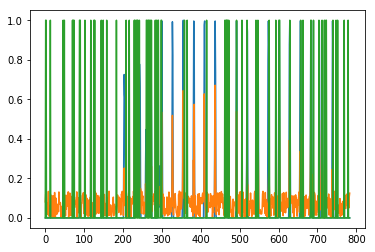

In [92]:
plt.plot(x_test)
plt.plot(x_noise)
print np.mean(x_test), np.mean(x_noise)
plt.plot(np.random.binomial(1,x_noise))

In [64]:
np.where(np.random.multinomial(1, np.ones(28)/28) == 1)[0][0]

23

In [119]:
lik_predictive

{0: {0: {(0, 0): array([  1.00000000e-16,   1.00000000e-16,   1.00000000e-16,
            1.00000000e-16,   1.00000000e-16,   1.00000000e-16,
            1.00000000e-16,   1.00000000e-16,   1.00000000e-16,
            1.00000000e-16])},
  1: {(0, 0): array([  1.00000000e-16,   1.00000000e-16,   1.00000000e-16,
            1.00000000e-16,   1.00000000e-16,   1.00000000e-16,
            1.00000000e-16,   1.00000000e-16,   1.00000000e-16,
            1.00000000e-16])},
  2: {(0, 0): array([  1.00000000e-16,   1.00000000e-16,   1.00000000e-16,
            1.00000000e-16,   1.00000000e-16,   1.00000000e-16,
            1.00000000e-16,   1.00000000e-16,   1.00000000e-16,
            1.00000000e-16]),
   (0, 1): array([  1.00000000e-16,   1.00000000e-16,   1.00000000e-16,
            1.00000000e-16,   1.00000000e-16,   1.00000000e-16,
            1.00000000e-16,   1.00000000e-16,   1.00000000e-16,
            1.00000000e-16]),
   (1, 0): array([  1.00000000e-16,   1.00000000e-16,   1.00000000